#News Headlines Dataset For Sarcasm Detection

About this dataset

Each record consists of three attributes:

- is_sarcastic: 1 if the record is sarcastic otherwise 0.

- headline: the headline of the news article.

- article_link: link to the original news article. Useful for collecting supplementary .

The dataset file is in the json format which needs to be read as a python object for further preprocessing.

## Loading the dataset
Importing the json library and converting the json objects into their respective python objects

In [2]:
import json # Importing the json library
data = [] # Creating an empty list of data 
with open("/content/Sarcasm_Headlines_Dataset_v2.json", "r") as f:
  for line in f:
    line.replace("0", '"0"')
    line.replace("1", '"1"')
    data.append(json.loads(line))

Viewing the first five examples in data

In [3]:
data[:5]

[{'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html',
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031',
  'headline': 'inclement weather prevents liar from getting to work',
  'is_sarcastic': 1},
 {'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546',
  'headline': "mother comes pretty close to using wor

Creating a list all the features (headline) and labels (is_sarcastic)

In [4]:
sentences = []
labels = []
for line in data:
  sentences.append(line["headline"])
  labels.append(line["is_sarcastic"])

# Printing out the length of sentences and labels
len(sentences), len(labels)

(28619, 28619)

Splitting the dataset into train and test sets, test set will be used for model validation

In [5]:
split_size = int(0.8*len(sentences))
train_sentences = sentences[:split_size]
train_labels = labels[:split_size]
test_sentences = sentences[split_size:]
test_labels = labels[split_size:]

# Printing out the length of train and test features and labels
len(train_sentences), len(train_labels), len(test_sentences), len(test_labels)

(22895, 22895, 5724, 5724)

Viewing the first 5 sentences from train_sentences

In [6]:
train_sentences[:5]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly"]

Check for the length of each sentence in our training sentences

In [7]:
length_of_sentence = [len(sentence.split()) for sentence in train_sentences]
length_of_sentence[:5]

[8, 13, 7, 8, 9]

Maximum length of the sentence in our training sentences

In [8]:
max_length = max(length_of_sentence)
max_length

151

Check out the distribution of the length of the sentences

(array([2.2146e+04, 7.4800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  2. ,  16.9,  31.8,  46.7,  61.6,  76.5,  91.4, 106.3, 121.2,
        136.1, 151. ]),
 <a list of 10 Patch objects>)

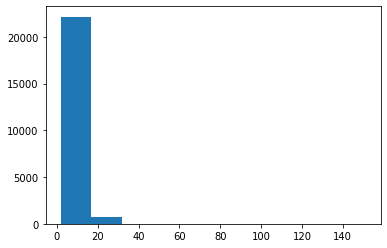

In [9]:
import matplotlib.pyplot as plt
plt.hist(length_of_sentence)

Check for the length of the sentence which covers 95% of the traininig sentences

In [10]:
import numpy as np
MAX_LEN = int(np.percentile(length_of_sentence, 95))
MAX_LEN 

16

Defining the vocabulary size and the out pf vocabulary token 

In [11]:
NUM_WORDS = 10000 # size of our vocabulary
OOV_TOKEN = "<OOV>" # out of vocabulary tokens

Tokenizing the sentences

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating an object of Tokenizer
tokenizer = Tokenizer(num_words = NUM_WORDS, oov_token=OOV_TOKEN)
# Fit the tokenizer object on train_sentences
tokenizer.fit_on_texts(train_sentences)
# Check the word_index
word_index = tokenizer.word_index
# Convert the tokenized words in the training sentences into training sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Padding each sentence so that all the training sentences have the same number of words or length to make learning easy
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding="post", truncating="post")
# Repeating the above process for test sentences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding="post", truncating="post")

Converting the train and test labels from lists into numpy arrays

In [16]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Building the model

In [25]:
# The model consists of and Emebedding layer followed by Conv1D, Bidirectional with LSTM and a final Dense layer
model_1 = tf.keras.Sequential([
 tf.keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=128, input_length=MAX_LEN),
 tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
 tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Define ModelCheckPoint callbacks
checkpoint_filepath = "model_checkpoints_weights/checkpoint.ckpt"
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, 
                                                       monitor='val_accuracy', 
                                                       verbose=0, 
                                                       save_best_only=False,
                                                       save_weights_only=False,
                                                       save_freq='epoch')
    

# Fit the model
model_1.fit(train_padded,
            train_labels,
            epochs=15,
            validation_data=(test_padded, test_labels),
            callbacks=[model_check_point])

Epoch 1/15
716/716 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8227

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 54s 66ms/step - loss: 0.3726 - accuracy: 0.8227 - val_loss: 0.3143 - val_accuracy: 0.8611
Epoch 2/15
716/716 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9401

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.1579 - accuracy: 0.9401 - val_loss: 0.3441 - val_accuracy: 0.8622
Epoch 3/15
715/716 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9804

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 44s 62ms/step - loss: 0.0567 - accuracy: 0.9804 - val_loss: 0.4653 - val_accuracy: 0.8550
Epoch 4/15
715/716 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9924

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.6154 - val_accuracy: 0.8546
Epoch 5/15
714/716 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9952

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0144 - accuracy: 0.9952 - val_loss: 0.5263 - val_accuracy: 0.8522
Epoch 6/15
714/716 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9974

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.6455 - val_accuracy: 0.8567
Epoch 7/15
715/716 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9978

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.6868 - val_accuracy: 0.8494
Epoch 8/15
714/716 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9975

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 44s 62ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.7920 - val_accuracy: 0.8510
Epoch 9/15
714/716 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9978

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.9008 - val_accuracy: 0.8464
Epoch 10/15
716/716 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9985

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.8044 - val_accuracy: 0.8473
Epoch 11/15
716/716 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9984

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.8510 - val_accuracy: 0.8491
Epoch 12/15
716/716 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9983

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 64ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.8908 - val_accuracy: 0.8393
Epoch 13/15
715/716 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9985

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 46s 65ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss: 0.9026 - val_accuracy: 0.8473
Epoch 14/15
715/716 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.9652 - val_accuracy: 0.8501
Epoch 15/15
714/716 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995

INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/assets


716/716 [==============================] - 45s 63ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.9146 - val_accuracy: 0.8489


Load the model saved from the model check point callbacks

In [29]:
saved_model = tf.keras.models.load_model(checkpoint_filepath)

Evaluating the saved model on the test set

In [30]:
saved_model.evaluate(test_padded, test_labels)

179/179 [==============================] - 3s 8ms/step - loss: 0.9146 - accuracy: 0.8489


[0.9145625829696655, 0.8488819003105164]